# ИМПОРТ БИБЛИОТЕК


In [ ]:
from google.colab import files # модуль для загрузки файлов в colab
import numpy as np # библиотека для работы с массивами данных

from tensorflow.keras.models import Model, load_model # из кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input # из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.optimizers import RMSprop, Adadelta # из кераса загружаем выбранный оптимизатор
from tensorflow.keras.preprocessing.sequence import pad_sequences # загружаем метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence # загружаем токенизатор кераса для обработки текста
from tensorflow.keras import utils # загружаем утилиты кераса для one hot кодировки
from tensorflow.keras.utils import plot_model # удобный график для визуализации архитектуры модели

import yaml # импортируем модуль для удобной работы с файлами

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# НАСТРОЙКИ

In [ ]:
DIR = '/content/drive/MyDrive/Colab Notebooks/ОБУЧЕНИЕ/УИИ/17. Генерация текста/files'

# ПАРСИНГ ДАННЫХ

## Открываем данные с диалогами
Используем укороченную версию, т.к. для длинной версии не хватает ОЗУ

In [ ]:
text = open(DIR + '/ultra_pro.yml', 'r')
document = yaml.safe_load(text) # Загружаем файл *глоссарий, безопасно загружает подмножество YAML, в основном используется, если документ поступает из ненадежного источника.
yaml_list = document['разговоры'] # загружаем диалоги из файла и заносим в yaml_list 
print(f'Количество пар вопрос-ответ : {len(yaml_list)}')
print(f'Пример диалога : {yaml_list[20]}')
text.close()

Количество пар вопрос-ответ : 119
Пример диалога : ['Помню в 16 лет в 16 градусной воде Волгу переплывал туда и обратно.', 'Ну вот это вообще круто, в 16.']


## Разбираем вопросы - ответы

In [ ]:
questions = list() # Список вопросов
answ = list() # Список ответов без очистки

# Перебираем список диалогов
# Если в ответе не одна фраза - то сцепляем сколько есть
for yaml_item in yaml_list:
  if len(yaml_item) > 2 :  # Если список содержит более 2 элементов
    questions.append(yaml_item[0])  # Первый элемент списка - будет вопросом
    replies = yaml_item[1:]  # Ответная часть из оставшихся ячеек
    ans = ''  # Соберём ответ в одну строку
    for rep in replies:
      ans += ' ' + rep 
    answ.append(ans)  # Добавим в список ответов
  elif len(yaml_item) == 2:  # Если на 1 вопрос приходится 1 ответ
    questions.append(yaml_item[0])  # Первая реплика - вопрос
    answ.append(yaml_item[1])  # Вторая реплика - ответ

# Очищаем строки с неопределенным типом ответов
answers_clean = list()
for i in range(len(answ)):
  if type(answ[i]) == str:
    answers_clean.append(answ[i]) #если тип - строка, то добавляем в ответы
  else:
    questions.pop(i)  # Если не строка, то ответ не добавился, и плюс убираем соответствующий вопрос

# Сделаем теги-метки для начала и конца ответов
answers = list()
for i in range(len(answers_clean)):
  answers.append( '<START> ' + answers_clean[i] + ' <END>' )

# Выведем обновленные данные на экран
print(f'Вопрос : {questions[20]}')
print(f'Ответ : {answers[20]}')

Вопрос : Помню в 16 лет в 16 градусной воде Волгу переплывал туда и обратно.
Ответ : <START> Ну вот это вообще круто, в 16. <END>


## Токенизатор

In [ ]:
num_words = 1000
tokenizer = Tokenizer(
    num_words=num_words,
    filters='!"#$%&*+,-–—./…;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
    lower=True, 
    split=' ', 
    char_level=False, 
    oov_token='unknown'
)

tokenizer.fit_on_texts(questions + answers)  # Загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
word_list = list(tokenizer.word_index.items())  # Список с cодержимым словаря
word_list_len = len(word_list) + 1  # Размер словаря
print(f'Фрагмент словаря : {word_list[:50]}')
print(f'Размер словаря : {word_list_len}')

Фрагмент словаря : [('unknown', 1), ('start', 2), ('end', 3), ('в', 4), ('на', 5), ('не', 6), ('с', 7), ('и', 8), ('я', 9), ('ты', 10), ('что', 11), ('это', 12), ('а', 13), ('да', 14), ('у', 15), ('за', 16), ('ну', 17), ('так', 18), ('по', 19), ('толь', 20), ('то', 21), ('меня', 22), ('км', 23), ('как', 24), ('завтра', 25), ('если', 26), ('привет', 27), ('только', 28), ('ещё', 29), ('очень', 30), ('к', 31), ('нет', 32), ('был', 33), ('хорошо', 34), ('ии', 35), ('мы', 36), ('зачем', 37), ('есть', 38), ('доброго', 39), ('утра', 40), ('уже', 41), ('2', 42), ('надо', 43), ('там', 44), ('бодрого', 45), ('же', 46), ('всё', 47), ('вот', 48), ('ни', 49), ('друзья', 50)]
Размер словаря : 877


# ПОДГОТОВКА ВЫБОРКИ

## Вопросы

In [ ]:
questions_sec = tokenizer.texts_to_sequences(questions)  # Разбиваем текст вопросов на последовательности индексов
questions_sec_max = max([ len(x) for x in questions_sec])  # Находим длину самого большого вопроса
# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
questions_pad = pad_sequences(questions_sec, maxlen=questions_sec_max, padding='post')

# Предподготавливаем данные для входа в сеть
print(f'Пример оригинального вопроса на вход : {questions[100]}') 
print(f'Пример кодированного вопроса на вход : {questions_pad[100]}') 
print(f'Размеры закодированного массива вопросов на вход : {format(questions_pad.shape)}') 
print(f'Установленная длина вопросов на вход : {questions_sec_max}') 

Пример оригинального вопроса на вход : ИИ не уберёт низкооплачиваемые профессии
Пример кодированного вопроса на вход : [ 35   6 485 486 487   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]
Размеры закодированного массива вопросов на вход : (119, 19)
Установленная длина вопросов на вход : 19


## Ответы входные

In [ ]:
answers_seq = tokenizer.texts_to_sequences(answers)  # Разбиваем текст ответов на последовательности индексов
answers_seq_max = max([len(x) for x in answers_seq])  # Уточняем длину самого большого ответа
answers_pad = pad_sequences(answers_seq, maxlen=answers_seq_max, padding='post')  # Делаем последовательности одной длины, заполняя нулями более короткие ответы

# Предподготавливаем данные для входа в сеть
print(f'Пример оригинального ответа на вход: {answers[10]}') 
print(f'Пример раскодированного ответа на вход : {answers_pad[20]}') 
print(f'Размеры раскодированного массива ответов на вход : {answers_pad.shape}') 
print(f'Установленная длина ответов на вход : {answers_seq_max}') 

Пример оригинального ответа на вход: <START> Ты можешь тратить много энергии на пробивание своим ростком асфальта над тобой. А можешь сотрудничать с другими ростками <END>
Пример раскодированного ответа на вход : [  2  17  48  12 596 107   4  80   3   0   0   0   0   0   0   0   0   0
   0   0]
Размеры раскодированного массива ответов на вход : (119, 20)
Установленная длина ответов на вход : 20


## Ответы выходные

In [ ]:
answers_seq = tokenizer.texts_to_sequences(answers)  # Разбиваем текст ответов на последовательности индексов
for i in range(len(answers_seq)):  # Для разбитых на последовательности ответов
  answers_seq[i] = answers_seq[i][1:]  # Избавляемся от тега <START>
answers_pad = pad_sequences(answers_seq, maxlen=answers_seq_max , padding='post')  # Делаем последовательности одной длины, заполняя нулями более короткие ответы

answers_one_hot = utils.to_categorical(answers_pad, word_list_len) # переводим в one hot vector
answers_one_hot_np = np.array(answers_one_hot) # и сохраняем в виде массива numpy

# Предподготавливаем данные для входа в сеть
print(f'Пример раскодированного ответа на вход : {answers_pad[100][:21]}')  
print(f'Пример раскодированного ответа на выход : {answers_one_hot_np[100][4][:21]}') 
print(f'Размеры раскодированного массива ответов на выход : {answers_one_hot_np.shape}')
print(f'Установленная длина вопросов на выход : {answers_seq_max}') 

Пример раскодированного ответа на вход : [212   8 814 815 816   5 817 818  35   8 819   3   0   0   0   0   0   0
   0   0]
Пример раскодированного ответа на выход : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодированного массива ответов на выход : (119, 20, 877)
Установленная длина вопросов на выход : 20


# НЕЙРОННАЯ СЕТЬ

## Входной слой, encoder

In [ ]:
encoder_input = Input(shape=(None , ))  # Размеры на входе сетки
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
encoder_embedding = Embedding(word_list_len, 200 , mask_zero=True) (encoder_input)  # mask_zero=True - не учитываем нули, которыми мы добивали предложение до нужной длины
# Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoder_outputs, state_h , state_c = LSTM(200, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

## Выходной слой, decoder

In [ ]:
decoder_input = Input(shape=(None, ))  # Размеры на входе сетки (здесь будет decoder_for_input)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoder_embedding = Embedding(word_list_len, 200, mask_zero=True) (decoder_input) 
# Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c
decoder_LSTM = LSTM(200, return_state=True, return_sequences=True)

decoder_output , _ , _ = decoder_LSTM (decoder_embedding, initial_state=encoder_states)
# И от LSTM'а сигнал decoder_output пропускаем через полносвязный слой с софтмаксом на выходе
decoder_dense = Dense(word_list_len, activation='softmax') 
output = decoder_dense(decoder_output)

## Собираем тренировочную модель нейросети

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    175400      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    175400      input_2[0][0]                    
______________________________________________________________________________________________

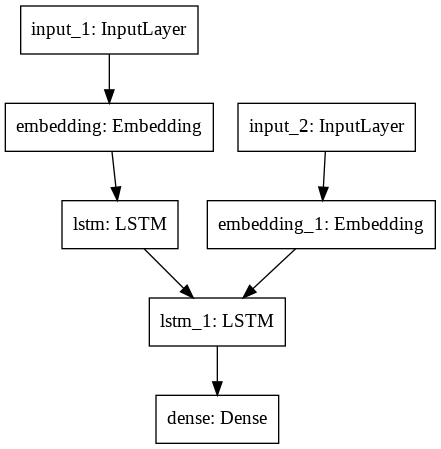

In [ ]:
model = Model([encoder_input, decoder_input], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

print(model.summary()) # выведем на экран информацию о построенной модели нейросети
plot_model(model) # и построим график для визуализации слоев и связей между ними

In [ ]:
model.fit([questions_pad , answers_pad], answers_one_hot_np, batch_size=50, epochs=500) 
# model.save(DIR + '/ultra_pro_rms.h5')

Epoch 1/500
3/3 [==============================] - 0s 30ms/step - loss: 0.1530
Epoch 2/500
3/3 [==============================] - 0s 32ms/step - loss: 0.1457
Epoch 3/500
3/3 [==============================] - 0s 29ms/step - loss: 0.1409
Epoch 4/500
3/3 [==============================] - 0s 31ms/step - loss: 0.1376
Epoch 5/500
3/3 [==============================] - 0s 30ms/step - loss: 0.1312
Epoch 6/500
3/3 [==============================] - 0s 33ms/step - loss: 0.1159
Epoch 7/500
3/3 [==============================] - 0s 32ms/step - loss: 0.1074
Epoch 8/500
3/3 [==============================] - 0s 31ms/step - loss: 0.1004
Epoch 9/500
3/3 [==============================] - 0s 32ms/step - loss: 0.0958
Epoch 10/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0962
Epoch 11/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0860
Epoch 12/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0817
Epoch 13/500
3/3 [==============================]

In [ ]:
# model.load_weights(DIR + '/test_rms.h5')

# НЕЙРОСЕТЬ С ГЕНЕРАЦИЕЙ ОТВЕТОВ

## Функция создания модели

In [ ]:
def create_model():
  # Определим модель кодера, на входе далее будут закодированные вопросы(questions_pad), на выходе состояния state_h, state_c
  encoder_model = Model(encoder_input, encoder_states) 

  decoder_input_h = Input(shape=(200 ,))  # Обозначим размерность для входного слоя с состоянием state_h
  decoder_input_c = Input(shape=(200 ,))  # Обозначим размерность для входного слоя с состоянием state_c

  decoder_state_input = [decoder_input_h, decoder_input_c]  # Возьмем оба inputs вместе и запишем в decoder_state_input

  # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
  decoder_output, state_h, state_c = decoder_LSTM(decoder_embedding, initial_state=decoder_state_input)
  decoder_state = [state_h, state_c]  # LSTM даст нам новые состояния
  decoder_output = decoder_dense(decoder_output)  # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoder_model = Model([decoder_input] + decoder_state_input, [decoder_output] + decoder_state)

  return encoder_model , decoder_model

## Функция, преобразующая вопрос пользователя
В последовательность индексов

In [ ]:
def str_to_token(question: str):  # Функция принимает строку на вход (предложение с вопросом)
  question_seq = tokenizer.texts_to_sequences([question])
  return question_seq

## Создаём модель и запускаем

In [ ]:
def start_model():
  encoder_model , decoder_model = create_model()  # Получаем модели энкодера и декодера

  for _ in range(3):  # Итерации, 3 вопроса в цикле
    # Получаем состояние от энкодера на заданный вопрос.
    states_values = encoder_model.predict(str_to_token(input('Задайте вопрос : ' )))
    target_seq_zeros = np.zeros((1, 1))  # Создаём массив, заполненный нулями  
    target_seq_zeros[0, 0] = tokenizer.word_index['start'] # В первый элемент массива пометим начальное слово 'start' в виде индекса

    generate_progress = True # Условие выполенения процесса генерации
    answer = ''  # Ответ
    while generate_progress : # Пока выполняется условие процесса генерации
      # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
      # Декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
      decoder_out , h , c = decoder_model.predict([target_seq_zeros] + states_values)

      #argmax по вектору decoder_out - найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
      word_index = np.argmax(decoder_out[0, 0, :]) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
      word_current = None  # Создаем переменную, в которую положим слово, преобразованное на естественный язык
      for word , index in tokenizer.word_index.items():
        if word_index == index: # Если индекс выбранного слова соответствует какому-то индексу из словаря
          answer += f' {word}'  # Cлово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
          word_current = word  # выбранное слово фиксируем в переменную word_current
      
      # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
      if word_current == 'end' or len(answer.split()) > answers_seq_max:
        generate_progress = False  # Условие прекращения генерации

      target_seq_zeros[0, 0] = word_index  # Заносим туда индекс выбранного слова
      states_values = [h, c]  # И состояния, обновленные декодером
      # Продолжаем цикл с обновленными параметрами
    
    print(answer[:-3]) # выводим ответ сгенерированный декодером

In [ ]:
start_model()

Задайте вопрос : бодрого утра
 бодрого бодрого бодрого бодрого бодрого бодрого бодрого бодрого бодрого бодрого бодрого бодрого бодрого бодрого бодрого бодрого бодрого бодрого бодрого бодрого бодр
Задайте вопрос : деда мороза не существует
 зачем ранишь ранишь ранишь палатка палатка палатка одноразово 
Задайте вопрос : не знакомый нейронке текст
 ахахаха ты ты ты ты ты ты ты ты ты ты ты ты ты ты ты ты ты ты ты


# ВЫВОД
База с вопросами и ответами небольшая, поэтому такой вот диалог.